In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from torch.utils.data import DataLoader, TensorDataset

from models import Autoencoder, IDEC
from utils import load_mnist
from utils import plot_ae_reconstructions, plot_all_reconstructions, plot_dec_centers, plot_losses
from utils import plot_pca, plot_umap

/home/ilia/PycharmProjects/bachelor/.venv12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
input_dim = 784
latent_dim = 10
n_clusters = 10
pretrain_epochs = 10
finetune_epochs = 10
learning_rate = 0.1
gamma = 0.1,

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# data, labels = load_digits(return_X_y=True)
# scaler = MinMaxScaler()
# data = scaler.fit_transform(data)
#
# tensor_x = torch.Tensor(data).to(device)
#
# indices = torch.arange(len(tensor_x)).to(device)
# dataset = TensorDataset(tensor_x, indices)
# train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
train_dataset, test_data = load_mnist()

# We flatten to (N, 784) and scale to [0, 1]
data = train_dataset.data.float() / 255.0
data = data.view(-1, 784)

labels = train_dataset.targets.numpy()
tensor_x = data.to(device)

# Create dataset with indices to map each batch to a full P distribution
# This allows us to compute P globally but train in batches
indices = torch.arange(len(tensor_x)).to(device)
dataset = TensorDataset(tensor_x, indices)
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)

# Autoencoder Training

In [5]:
ae = Autoencoder(input_dim, latent_dim).to(device)

ae_optimizer = optim.Adam(ae.parameters(), lr=1e-3)
mse_loss = nn.MSELoss()

### Uncomment the lines below for custom training

In [6]:
# img_indices = [50563, 10910, 57965]
# ae_losses, images = train_autoencoder(
#     ae,
#     train_loader,
#     ae_optimizer,
#     mse_loss,
#     epochs=10,
#     image_indices=img_indices,
# )

In [7]:
# checkpoint = {
#     "model_state": ae.state_dict(),
#     "losses": ae_losses,
#     "images": images
# }
#
# torch.save(ae.state_dict(), "../checkpoints/autoencoder_mnist_param.pth")
# torch.save(checkpoint, "../checkpoints/autoencoder_mnist_full.pth")

### Load pretrained Autoencoder

In [8]:
ae.load_state_dict(torch.load("../checkpoints/autoencoder_mnist.pth"))

checkpoint = torch.load("../checkpoints/autoencoder_full.pth", map_location="cpu")
# ae.load_state_dict(checkpoint["model_state"])
ae_losses = checkpoint["losses"]
images = checkpoint["images"]

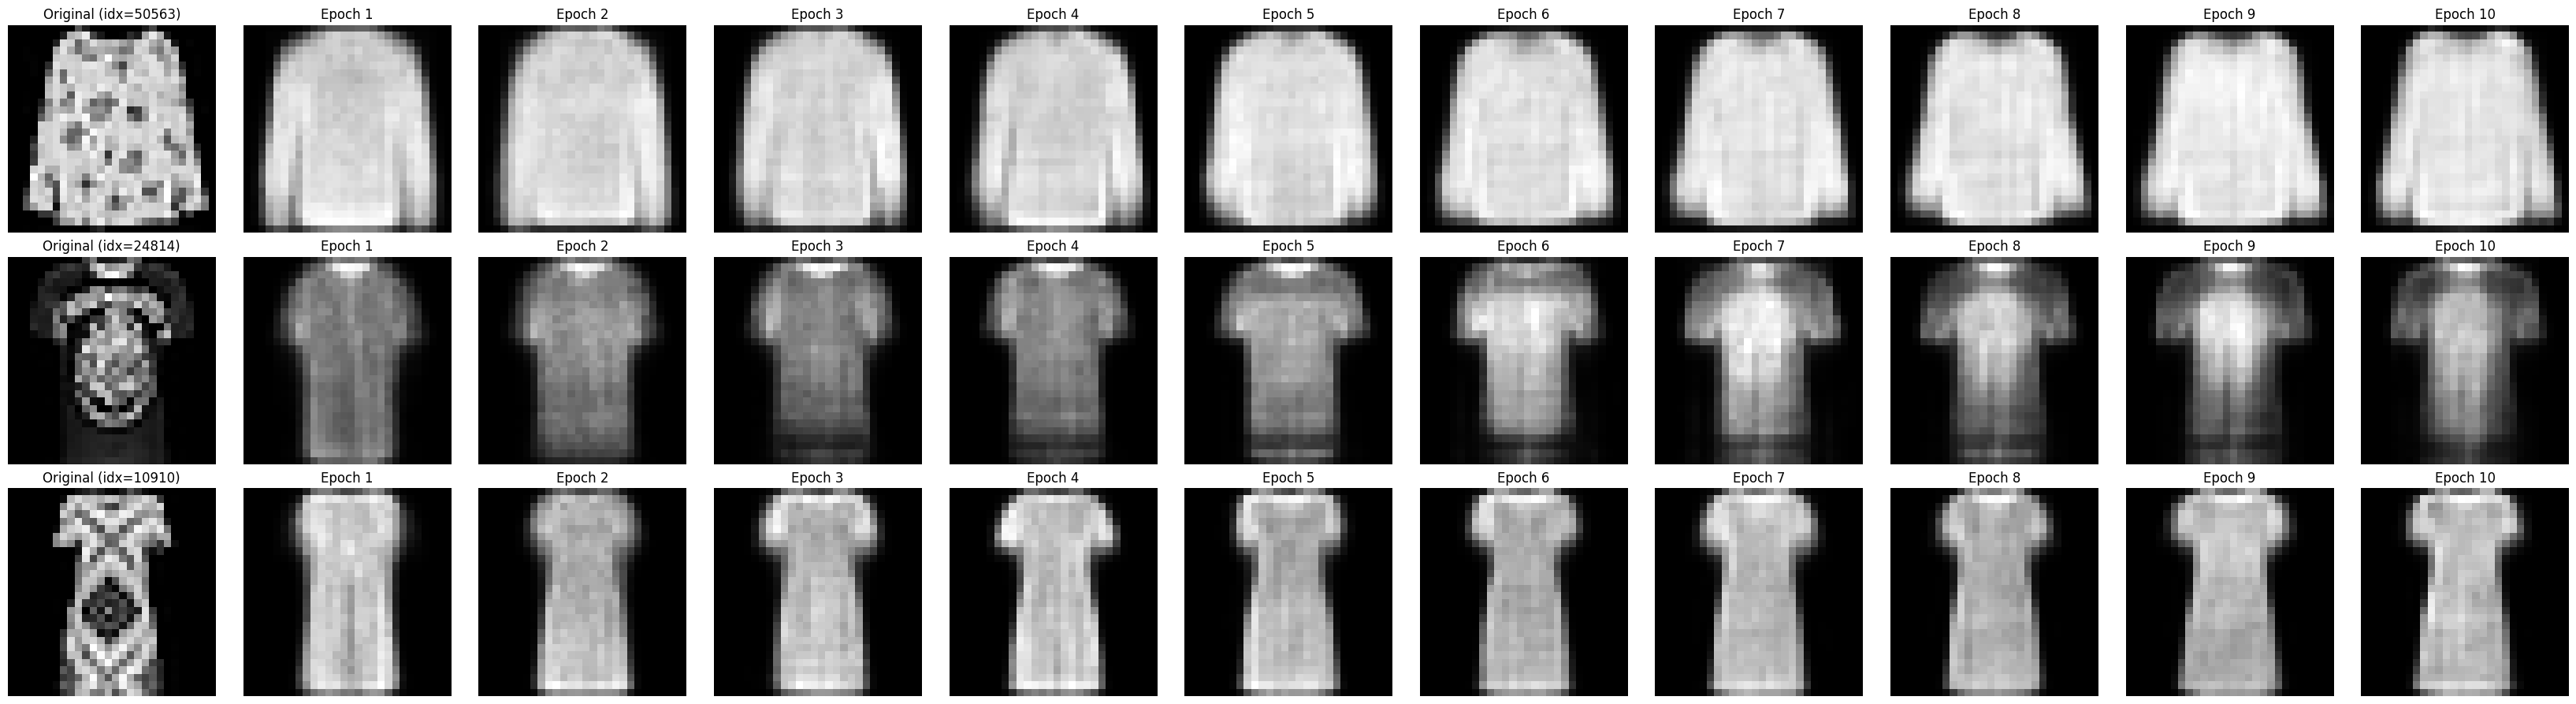

In [9]:
plot_all_reconstructions(images)

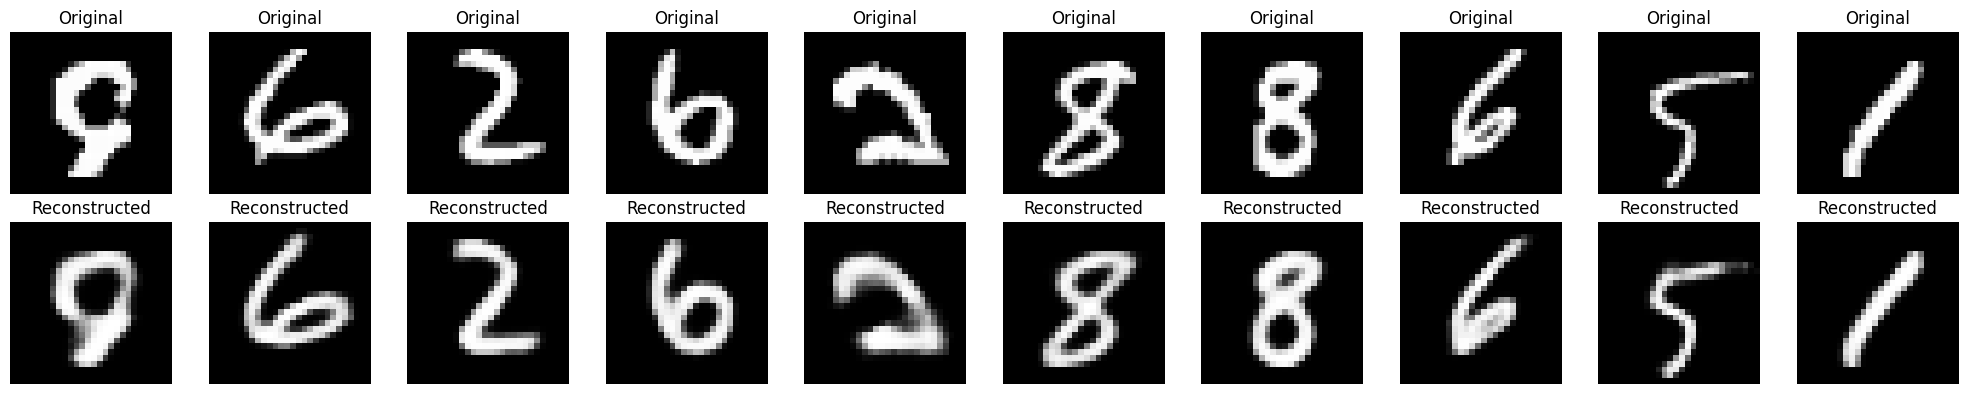

In [10]:
plot_ae_reconstructions(
    ae,
    train_dataset,
    n=10,
    device=device
)

# IDEC Training

In [11]:
idec = IDEC(ae, n_clusters, latent_dim).to(device)
# dec.initialize_centers(train_loader, device)

idec_optimizer = optim.SGD(idec.parameters(), lr=0.1, momentum=0.9)
# idec_optimizer = optim.Adam(idec.parameters(), lr=1e-3, betas=(0.9, 0.99))
kl_loss_fn = nn.KLDivLoss(reduction='batchmean')
mse_loss_fn = nn.MSELoss()

### Uncomment the lines below for custom training


In [12]:
# losses, kl_losses, mse_losses = train_idec(
#     idec,
#     train_loader,
#     idec_optimizer,
#     kl_loss_fn,
#     mse_loss_fn,
#     tensor_x,
#     epochs=100,
#     gamma=0.1,
#     device=device,
# )

In [13]:
# torch.save(idec.state_dict(), "../checkpoints/idec_mnist.pth")

### Load pretrained Autoencoder

In [14]:
idec.load_state_dict(torch.load("../checkpoints/idec_mnist.pth"))
idec.eval()

IDEC(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=500, bias=True)
      (1): ReLU()
      (2): Linear(in_features=500, out_features=500, bias=True)
      (3): ReLU()
      (4): Linear(in_features=500, out_features=2000, bias=True)
      (5): ReLU()
      (6): Linear(in_features=2000, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=2000, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2000, out_features=500, bias=True)
      (3): ReLU()
      (4): Linear(in_features=500, out_features=500, bias=True)
      (5): ReLU()
      (6): Linear(in_features=500, out_features=784, bias=True)
      (7): Sigmoid()
    )
  )
)

# Model evaluation

In [15]:
idec.eval()
with torch.no_grad():
    q_final, full_z_np, full_recon = idec(tensor_x)
    full_z_np = full_z_np.cpu().numpy()
    full_recon = full_recon.cpu().numpy()
    pred_labels = torch.argmax(q_final, dim=1).cpu().numpy()

ari = adjusted_rand_score(labels, pred_labels)
nmi = normalized_mutual_info_score(labels, pred_labels)

print(f"Adjusted Rand Score: {ari:.4f}")
print(f"Normalized Mutual Information : {nmi:.4f}")
print(f"Predicted Cluster Counts: {np.bincount(pred_labels)}")

Adjusted Rand Score: 0.7729
Normalized Mutual Information : 0.8273
Predicted Cluster Counts: [5436 6124 5948 8050 6195 5043 5790 4066 6764 6584]


# Plot results

In [16]:
plot_losses(
    idec_total=losses,
    idec_kl=kl_losses,
    idec_recon=mse_losses
)

NameError: name 'losses' is not defined

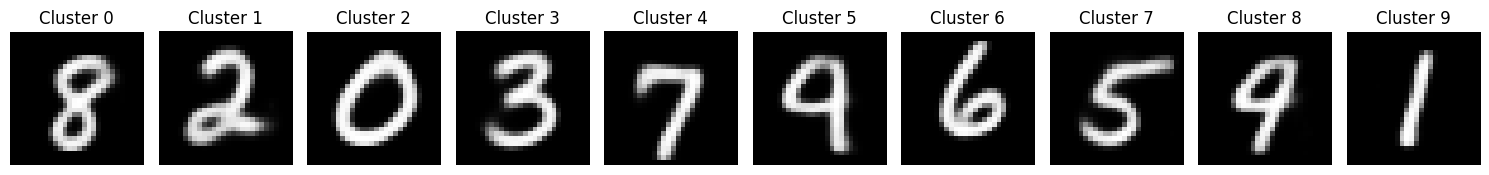

In [17]:
plot_dec_centers(idec, ae)

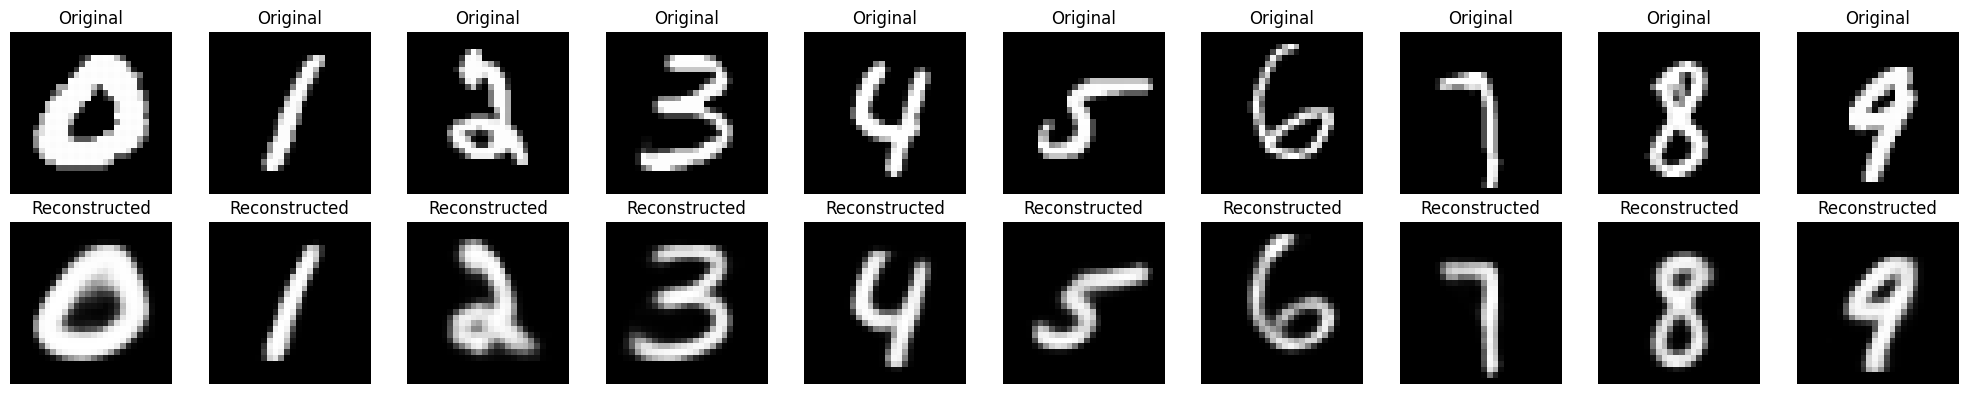

In [18]:
indices = []
current_labels = 0

while True:
    idx = torch.randint(len(train_dataset), size=(1,)).item()

    img, label = train_dataset[idx]
    if label == current_labels:
        indices.append(idx)
        current_labels += 1

    if len(indices) == 10:
        break

plot_ae_reconstructions(ae, train_dataset, indices=indices)

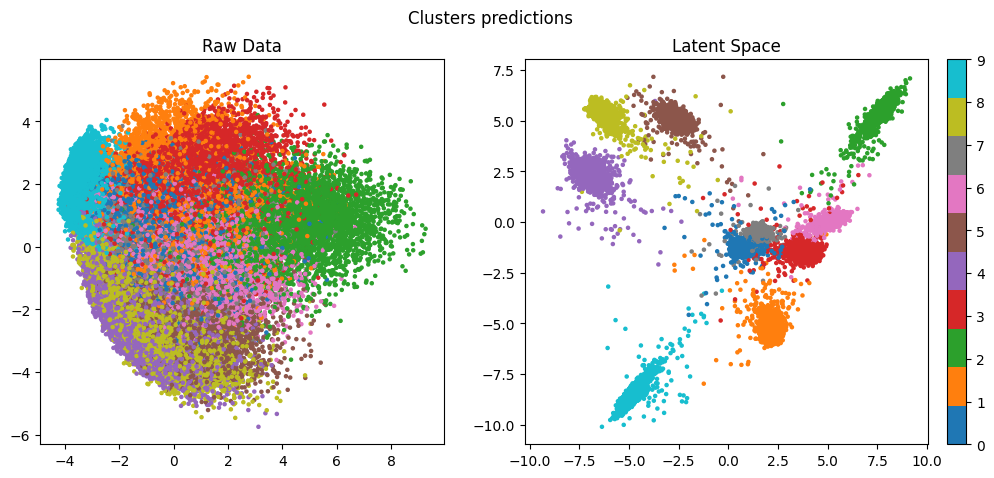

In [19]:
plot_pca(data, full_z_np, pred_labels, title='Clusters predictions')

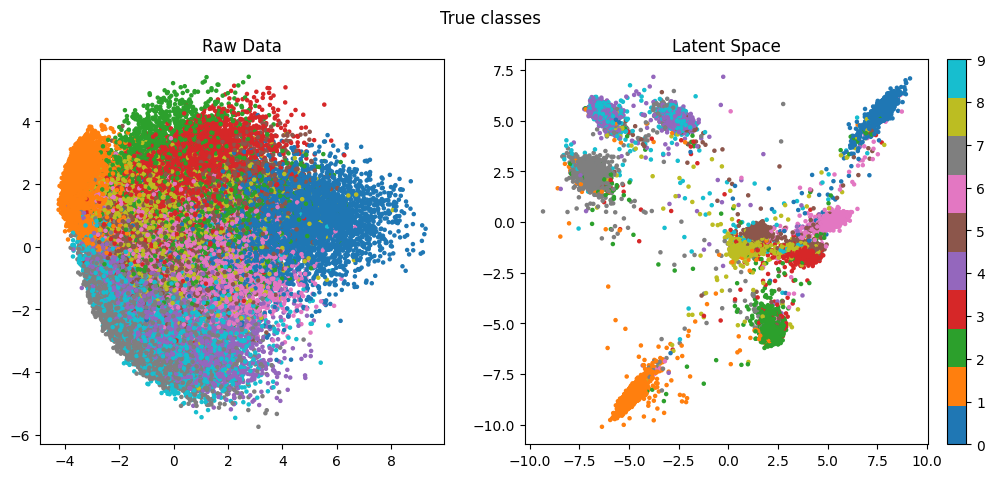

In [20]:
plot_pca(data, full_z_np, labels, title='True classes')

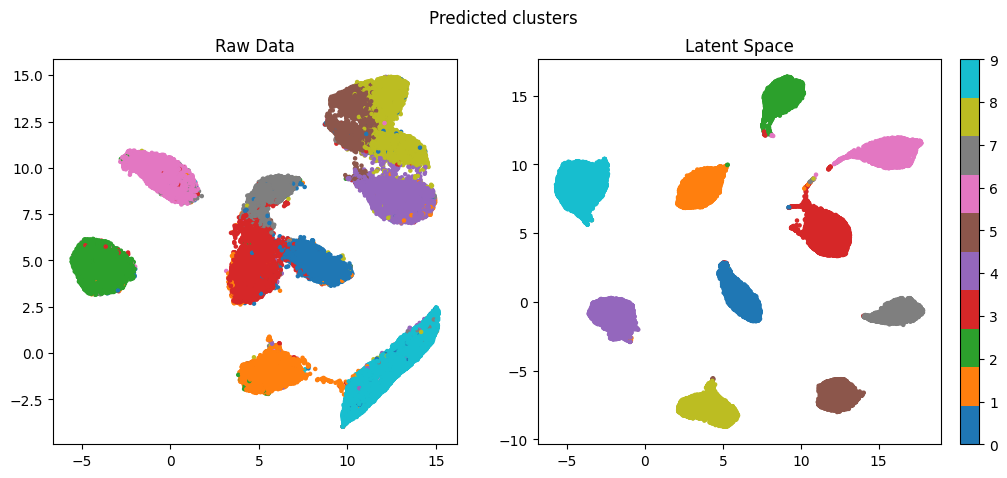

In [21]:
plot_umap(data, full_z_np, pred_labels, title='Predicted clusters')

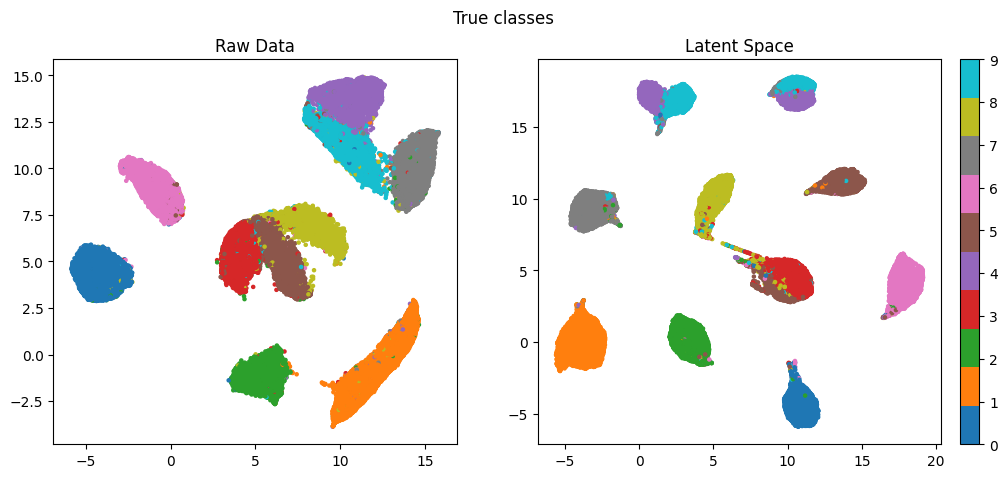

In [22]:
plot_umap(data, full_z_np, labels, title='True classes')